In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt  # plotting
import numpy as np  # linear algebra
import math

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    auc,
    precision_score,
    recall_score,
    precision_recall_curve,
    plot_confusion_matrix,
    f1_score,
)


from collections import Counter

from sklearn.datasets import make_classification

import copy

import warnings

from pykliep import DensityRatioEstimator

from amplify import amplifiedDF

<IPython.core.display.Javascript object>

# Data

### Malicious: Webgoat
### 100000 out of 4566477 packets

In [3]:
pd_webgoat = pd.read_csv("webgoat_flow_stats.csv")
pd_webgoat.drop(pd_webgoat.tail(1).index, inplace=True)
pd_webgoat["Type"] = "Malicious"

print(pd_webgoat.shape)

(485, 40)


<IPython.core.display.Javascript object>

### Malicious: Webgoat (138.68.177.159)

In [4]:
pd_webgoat = pd.read_csv("webgoat_138_68_177_159_flow_stats.csv")
# pd_webgoat.drop(pd_webgoat.tail(1).index, inplace=True)
pd_webgoat["Type"] = "Malicious"

print(pd_webgoat.shape)

(1139, 40)


<IPython.core.display.Javascript object>

### Malicious: Webgoat (138.68.177.159) - v4

In [5]:
pd_webgoat_v4 = pd.read_csv("webgoat_138_68_177_159_v4_flow_stats.csv")
# pd_webgoat_v4.drop(pd_webgoat_v4.tail(1).index, inplace=True)
pd_webgoat_v4["Type"] = "Malicious"

print(pd_webgoat_v4.shape)

(860, 40)


<IPython.core.display.Javascript object>

### Malicious: Ransomware

In [6]:
pd_ransomware = pd.read_csv("Razi_15012021_flow_stats.csv")
# pd_webgoat_v4.drop(pd_webgoat_v4.tail(1).index, inplace=True)
pd_ransomware["Type"] = "Malicious"

pd_ransomware2 = amplifiedDF(pd_ransomware, True, 10, 0.1)

print(pd_ransomware.shape, pd_ransomware2.shape)

(16, 40) (160, 42)


/Users/siddharthsatpathy/Work/jupyter_nbs/amplify.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_ch[col] = pd_ch[col] + noise


<IPython.core.display.Javascript object>

### Malicious (Stratosphere)

### Malicious (Metasploit)

In [6]:
pd_malicious = pd.read_csv("metasploit_flow_stats.csv")
# pd_malicious.drop(pd_malicious.tail(1).index, inplace=True)
pd_malicious["Type"] = "Malicious"

print(pd_malicious.shape)

(136, 40)


<IPython.core.display.Javascript object>

### Malicious (Burp)

In [7]:
pd_burp = pd.read_csv("burp_attackType_sniper_payload_bruteforce_post_flow_stats.csv")
# pd_burp.drop(pd_burp.tail(1).index, inplace=True)
pd_burp["Type"] = "Malicious"

print(pd_burp.shape)

(1950, 40)


<IPython.core.display.Javascript object>

### Malicious (TPot - 143.198.72.237)

In [3]:
pd_tpot = pd.read_csv("tpot_143_198_72_237_honeypot_v1_flow_stats.csv")
# pd_tpot.drop(pd_tpot.tail(1).index, inplace=True)
pd_tpot["Type"] = "Malicious"

print(pd_tpot.shape)

(724, 40)


<IPython.core.display.Javascript object>

In [3]:
pd_tpot = pd.read_csv("tpot_honeypot_143_198_72_237_v2_flow_stats.csv")
# pd_tpot.drop(pd_tpot.tail(1).index, inplace=True)
pd_tpot["Type"] = "Malicious"

print(pd_tpot.shape)

(3893, 40)


<IPython.core.display.Javascript object>

### Vulnerabilities (RapidAPI)

#### Simulate more flows from original data

In [8]:
pd_malicious = pd.read_csv("rapidAPI_v3_flow_stats.csv")
pd_malicious.drop(pd_malicious.tail(0).index, inplace=True)
pd_malicious["Type"] = "Malicious"

pd_malicious_orig = pd_malicious.copy(deep=True)

print(pd_malicious.shape)

(11, 40)


<IPython.core.display.Javascript object>

### Benign: Apache Bench

In [10]:
pd_ab = pd.read_csv("apache_bench_stats.csv")
pd_ab.drop(pd_ab.tail(1).index, inplace=True)
pd_ab["Type"] = "Benign"

print(pd_ab.shape)

(6290, 39)


<IPython.core.display.Javascript object>

### Benign

In [4]:
pd_benign = pd.read_csv("benign_stratosphere_v2_flow_stats.csv")
# pd_benign.drop(pd_benign.tail(1).index, inplace=True)
pd_benign["Type"] = "Benign"

print(pd_benign.shape)

(14338, 40)


<IPython.core.display.Javascript object>

In [5]:
pd_benign2 = pd.read_csv("benign_stratosphere_v2_3_flow_stats.csv")
# pd_benign2.drop(pd_benign2.tail(1).index, inplace=True)
pd_benign2["Type"] = "Benign"

print(pd_benign2.shape)

(5536, 40)


<IPython.core.display.Javascript object>

### Subsample malicious

In [13]:
pd_webgoat_sample = pd_webgoat.sample(
    int(pd_benign.shape[0] * (1.0 / 99.0)), replace=False
)

print(pd_webgoat_sample.shape)

(144, 40)


<IPython.core.display.Javascript object>

In [6]:
pd_tpot_sample = pd_tpot.sample(int(pd_benign.shape[0] * (1.0 / 99.0)), replace=False)

print(pd_tpot_sample.shape)

(144, 40)


<IPython.core.display.Javascript object>

In [14]:
pd_malicious.shape, pd_webgoat_sample.shape, pd_benign.shape

((11, 40), (144, 40), (14338, 40))

<IPython.core.display.Javascript object>

In [15]:
# pd_malicious_sample = pd_malicious.sample(
#     int(pd_benign.shape[0] * (10.0 / 99.0)), replace=False
# )

# pd_malicious_sample = pd_malicious

# print(pd_malicious_sample.shape)

<IPython.core.display.Javascript object>

### Create combined malicious dataframe

In [15]:
pd_malicious2 = pd_malicious[
    list(np.intersect1d(pd_malicious.columns.values, pd_webgoat_sample.columns.values))
]

pd_comb_malicious = pd.concat([pd_malicious2, pd_webgoat_sample])

<IPython.core.display.Javascript object>

### Combined dataframe - Benign + malicious

In [7]:
## pd_comb = pd.concat([pd_malicious_sample, pd_benign])
## pd_comb = pd.concat([pd_webgoat_sample, pd_benign])
## pd_comb = pd.concat([pd_comb_malicious, pd_benign])
## pd_comb = pd.concat([pd_ransomware2, pd_benign])
pd_comb = pd.concat([pd_tpot_sample, pd_benign])

## Random shuffle of rows
pd_comb = pd_comb.sample(frac=1)

pd_comb.shape

(14482, 40)

<IPython.core.display.Javascript object>

In [8]:
pd_comb.head(3)

,fiveTuple,srcIP,dstIP,protocol,srcPort,dstPort,flowDuration,flowLength,fwdFlowLength,bwdFlowLength,...,bwdIATTotal,fwdIATMean,bwdIATMean,fwdIATStd,bwdIATStd,fwdIATMin,bwdIATMin,fwdIATMax,bwdIATMax,Type
4448,10.0.2.15--172.217.18.174--TCP--61669--443(https),10.0.2.15,172.217.18.174,TCP,61669,443(https),1.962059e+11,83.0,29.0,54.0,...,1.961872e+11,7.007317e+09,3.701645e+09,1.934820e+10,1.456334e+10,443000.0,28000.0,6.368852e+10,6.369700e+10,Benign
1924,192.168.1.191--151.249.90.198--TCP--49556--80(...,192.168.1.191,151.249.90.198,TCP,49556,80(http),0.000000e+00,83.0,24.0,59.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,Benign
6341,10.0.2.15--104.120.243.32--TCP--58436--443(https),10.0.2.15,104.120.243.32,TCP,58436,443(https),1.179883e+11,83.0,29.0,54.0,...,1.179533e+11,4.213734e+09,2.225533e+09,4.738800e+09,4.069869e+09,0.0,28000.0,1.009247e+10,1.009253e+10,Benign


<IPython.core.display.Javascript object>

In [9]:
colsPerTime = [
    "flowLength",
    "fwdFlowLength",
    "bwdFlowLength",
    "packetSizeTotal",
    "fwdPacketSizeTotal",
    "bwdPacketSizeTotal",
]

for feature in colsPerTime:
    pd_comb[feature + "PerTime"] = pd_comb[feature] / pd_comb["flowDuration"]

    #     pd_malicious_orig[feature + "PerTime"] = (
    #         pd_malicious_orig[feature] / pd_malicious_orig["flowDuration"]
    #     )

    #     pd_webgoat[feature + "PerTime"] = pd_webgoat[feature] / pd_webgoat["flowDuration"]

    #     pd_burp[feature + "PerTime"] = pd_burp[feature] / pd_burp["flowDuration"]

    #     pd_webgoat_v4[feature + "PerTime"] = (
    #         pd_webgoat_v4[feature] / pd_webgoat_v4["flowDuration"]
    #     )

    print(feature + "PerTime")

flowLengthPerTime
fwdFlowLengthPerTime
bwdFlowLengthPerTime
packetSizeTotalPerTime
fwdPacketSizeTotalPerTime
bwdPacketSizeTotalPerTime


<IPython.core.display.Javascript object>

In [10]:
pd_comb.columns

Index(['fiveTuple', 'srcIP', 'dstIP', 'protocol', 'srcPort', 'dstPort',
       'flowDuration', 'flowLength', 'fwdFlowLength', 'bwdFlowLength',
       'packetSizeTotal', 'packetSizeMean', 'packetSizeStd', 'packetSizeMin',
       'packetSizeMax', 'fwdPacketSizeTotal', 'bwdPacketSizeTotal',
       'fwdPacketSizeMean', 'bwdPacketSizeMean', 'fwdPacketSizeStd',
       'bwdPacketSizeStd', 'fwdPacketSizeMin', 'bwdPacketSizeMin',
       'fwdPacketSizeMax', 'bwdPacketSizeMax', 'IATMean', 'IATStd', 'IATMin',
       'IATMax', 'fwdIATTotal', 'bwdIATTotal', 'fwdIATMean', 'bwdIATMean',
       'fwdIATStd', 'bwdIATStd', 'fwdIATMin', 'bwdIATMin', 'fwdIATMax',
       'bwdIATMax', 'Type', 'flowLengthPerTime', 'fwdFlowLengthPerTime',
       'bwdFlowLengthPerTime', 'packetSizeTotalPerTime',
       'fwdPacketSizeTotalPerTime', 'bwdPacketSizeTotalPerTime'],
      dtype='object')

<IPython.core.display.Javascript object>

## Features

In [11]:
feature_cols = [
    #     "flowDuration",
    #     "flowLength",
    #     "fwdFlowLength",
    #     "bwdFlowLength",
    #     "packetSizeTotal",
    "packetSizeMean",
    "packetSizeStd",
    "packetSizeMin",
    "packetSizeMax",
    #     "fwdPacketSizeTotal",
    #     "bwdPacketSizeTotal",
    "fwdPacketSizeMean",
    "bwdPacketSizeMean",
    "fwdPacketSizeStd",
    "bwdPacketSizeStd",
    "fwdPacketSizeMin",
    "bwdPacketSizeMin",
    "fwdPacketSizeMax",
    "bwdPacketSizeMax",
    #     "IATMean",
    #     "IATStd",
    #     "IATMin",
    #     "IATMax",
    #     "fwdIATTotal",
    #     "bwdIATTotal",
    #     "fwdIATMean",
    #     "bwdIATMean",
    #     "fwdIATStd",
    #     "bwdIATStd",
    #     "fwdIATMin",
    #     "bwdIATMin",
    #     "fwdIATMax",
    #     "bwdIATMax",
    "flowLengthPerTime",
    "fwdFlowLengthPerTime",
    "bwdFlowLengthPerTime",
    "packetSizeTotalPerTime",
    "fwdPacketSizeTotalPerTime",
    "bwdPacketSizeTotalPerTime",
    "Type",
]

<IPython.core.display.Javascript object>

### Dataframe with chosen features

In [12]:
pd_comb_features = pd_comb[feature_cols]

<IPython.core.display.Javascript object>

In [23]:
pd_webgoat_v4_features = pd_webgoat_v4[feature_cols]

<IPython.core.display.Javascript object>

In [38]:
pd_burp_features = pd_burp[feature_cols]

<IPython.core.display.Javascript object>

In [24]:
pd_malicious_orig_features = pd_malicious_orig[feature_cols]

<IPython.core.display.Javascript object>

In [25]:
pd_webgoat_features = pd_webgoat[feature_cols]

<IPython.core.display.Javascript object>

### Feature importance plots

In [ ]:
'fwdIATMean', 'bwdPacketSizeMean', 'fwdPacketSizeMax',
       'packetSizeMax', 'IATMin', 'fwdPacketSizeMin', 'bwdPacketSizeMin',
       'packetSizeMin', 'bwdPacketSizeMax', 'fwdPacketSizeMean',
       'packetSizeMean', 'packetSizeStd', 'fwdPacketSizeStd',
       'packetSizeTotalPerTime', 'bwdFlowLengthPerTime',
       'fwdFlowLengthPerTime', 'flowLengthPerTime', 'bwdIATMax',
       'fwdIATMax', 'bwdIATMin', 'fwdIATMin', 'bwdIATStd', 'fwdIATStd',
       'bwdIATMean', 'IATMax', 'fwdPacketSizeTotalPerTime', 'IATStd',
       'IATMean', 'bwdPacketSizeStd', 'bwdPacketSizeTotalPerTime'

Text(0, 0.5, 'Density')

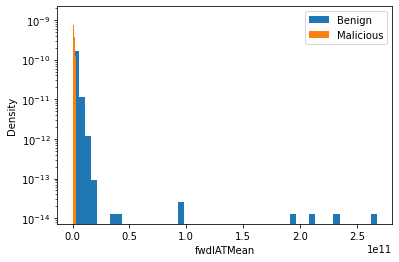

<IPython.core.display.Javascript object>

In [17]:
feature = "fwdIATMean"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign", zorder=2
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious", zorder=3
)


# plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

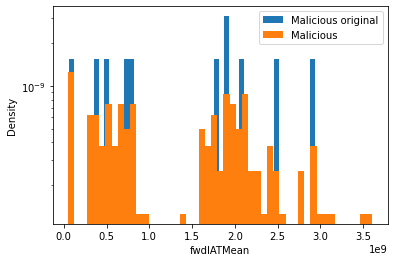

<IPython.core.display.Javascript object>

In [18]:
feature = "fwdIATMean"

df_benign = pd_malicious_orig
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Malicious original", zorder=2
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious", zorder=3
)


# plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

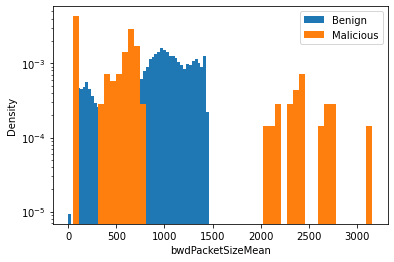

<IPython.core.display.Javascript object>

In [19]:
feature = "bwdPacketSizeMean"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign"
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious"
)


# plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

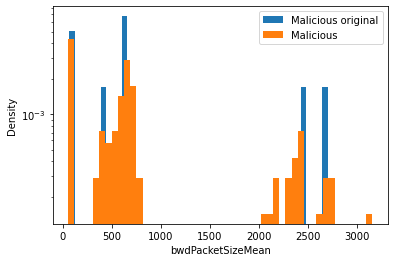

<IPython.core.display.Javascript object>

In [20]:
feature = "bwdPacketSizeMean"

df_benign = pd_malicious_orig
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Malicious original"
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious"
)


# plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

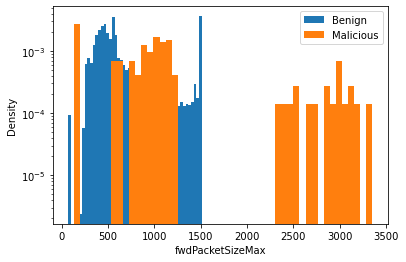

<IPython.core.display.Javascript object>

In [21]:
feature = "fwdPacketSizeMax"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign"
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious"
)


# plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

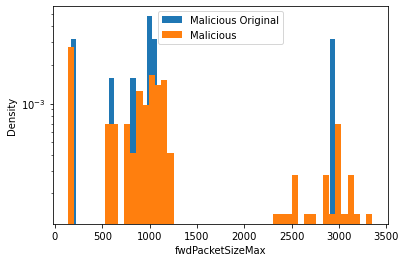

<IPython.core.display.Javascript object>

In [23]:
Actual analysis on such flows - flows suspicious - packets pass through rule engine


feature = "fwdPacketSizeMax"

df_benign = pd_malicious_orig
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Malicious Original"
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious"
)


# plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

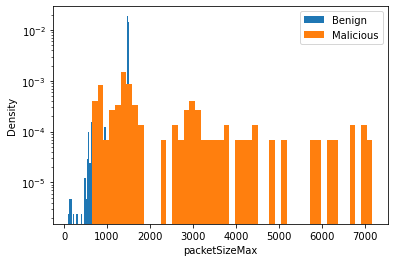

<IPython.core.display.Javascript object>

In [24]:
feature = "packetSizeMax"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign"
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious"
)


# plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

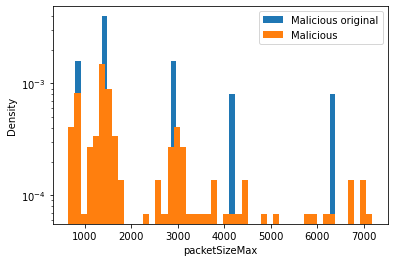

<IPython.core.display.Javascript object>

In [25]:
feature = "packetSizeMax"

df_benign = pd_malicious_orig
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Malicious original"
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious"
)


# plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

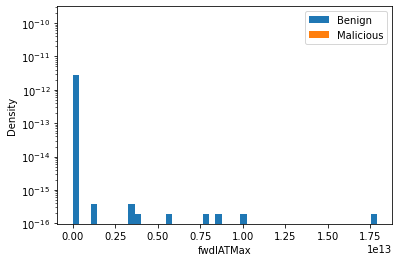

<IPython.core.display.Javascript object>

In [19]:
feature = "fwdIATMax"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign",
    zorder=2
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious", zorder=1
)


# plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

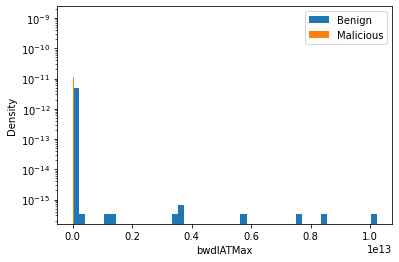

<IPython.core.display.Javascript object>

In [40]:
feature = "bwdIATMax"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign"
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious"
)


# plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


# Machine learning - feature importance

## Clean dataset

In [13]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    df_X = df.iloc[:, :-1]
    df_Y = df.iloc[:, -1]

    print(df.shape, df_X.shape, df_Y.shape)
    indices_to_keep = ~df_X.isin([np.nan, np.inf, -np.inf]).any(1)
    return df_X[indices_to_keep].astype(np.float64).values, df_Y[indices_to_keep].values

<IPython.core.display.Javascript object>

In [14]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

<IPython.core.display.Javascript object>

In [15]:
pd_comb_features_cp = pd_comb_features.copy(deep=True)

X, y = clean_dataset(pd_comb_features_cp)

(14479, 19) (14479, 18) (14479,)


<IPython.core.display.Javascript object>

In [16]:
print(X.shape, y.shape)

(8841, 18) (8841,)


<IPython.core.display.Javascript object>

## Train test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

<IPython.core.display.Javascript object>

In [18]:
X_train.shape, X_test.shape

((6188, 18), (2653, 18))

<IPython.core.display.Javascript object>

#### Kullback-Leibler Importance Estimation Procedure (KLIEP) for reweighting

In [31]:
class DensityRatioEstimator2:
    """
    Class to accomplish direct density estimation implementing the original KLIEP 
    algorithm from Direct Importance Estimation with Model Selection
    and Its Application to Covariate Shift Adaptation by Sugiyama et al. 
    
    The training set is distributed via 
                                            train ~ p(x)
    and the test set is distributed via 
                                            test ~ q(x).
                                            
    The KLIEP algorithm and its variants approximate w(x) = q(x) / p(x) directly. The predict function returns the
    estimate of w(x). The function w(x) can serve as sample weights for the training set during
    training to modify the expectation function that the model's loss function is optimized via,
    i.e.
    
            E_{x ~ w(x)p(x)} loss(x) = E_{x ~ q(x)} loss(x).
    
    Usage : 
        The fit method is used to run the KLIEP algorithm using LCV and returns value of J 
        trained on the entire training/test set with the best sigma found. 

        Use the predict method on the training set to determine the sample weights from the KLIEP algorithm.
    """

    def __init__(
        self,
        max_iter=5000,
        num_params=[0.1, 0.2],
        epsilon=1e-4,
        cv=3,
        sigmas=[0.01, 0.1, 0.25, 0.5, 0.75, 1],
        random_state=None,
        verbose=0,
    ):
        """ 
        Direct density estimation using an inner LCV loop to estimate the proper model. Can be used with sklearn
        cross validation methods with or without storing the inner CV. To use a standard grid search.
        
        
        max_iter : Number of iterations to perform
        num_params : List of number of test set vectors used to construct the approximation for inner LCV.
                     Must be a float. Original paper used 10%, i.e. =.1
        sigmas : List of sigmas to be used in inner LCV loop.
        epsilon : Additive factor in the iterative algorithm for numerical stability.
        """
        self.max_iter = max_iter
        self.num_params = num_params
        self.epsilon = epsilon
        self.verbose = verbose
        self.sigmas = sigmas
        self.cv = cv
        self.random_state = 0
        # self._sigma = None

    def fit(self, X_train, X_test, alpha_0=None):
        """ Uses cross validation to select sigma as in the original paper (LCV).
            In a break from sklearn convention, y=X_test.
            The parameter cv corresponds to R in the original paper.
            Once found, the best sigma is used to train on the full set."""

        # LCV loop, shuffle a copy in place for performance.
        cv = self.cv
        chunk = int(X_test.shape[0] / float(cv))
        if self.random_state is not None:
            np.random.seed(self.random_state)
        X_test_shuffled = X_test.copy()
        np.random.shuffle(X_test_shuffled)

        j_scores = {}

        if type(self.sigmas) != list:
            self.sigmas = [self.sigmas]

        if type(self.num_params) != list:
            self.num_params = [self.num_params]

        if (len(self.sigmas) * len(self.num_params)) > 1:
            # Inner LCV loop
            for num_param in self.num_params:
                for sigma in self.sigmas:
                    j_scores[(num_param, sigma)] = np.zeros(cv)
                    for k in range(1, cv + 1):
                        if self.verbose > 0:
                            print("Training: sigma: %s    R: %s" % (sigma, k))
                        X_test_fold = X_test_shuffled[(k - 1) * chunk : k * chunk, :]
                        j_scores[(num_param, sigma)][k - 1] = self._fit(
                            X_train=X_train,
                            X_test=X_test_fold,
                            num_parameters=num_param,
                            sigma=sigma,
                        )

                    print(j_scores)
                    j_scores[(num_param, sigma)] = np.mean(j_scores[(num_param, sigma)])

            sorted_scores = sorted(
                [x for x in j_scores.items() if np.isfinite(x[1])],
                key=lambda x: x[1],
                reverse=True,
            )

            if len(sorted_scores) == 0:
                warnings.warn("LCV failed to converge for all values of sigma.")
                return self

            self._sigma = sorted_scores[0][0][1]
            self._num_parameters = sorted_scores[0][0][0]
            self._j_scores = sorted_scores
        else:
            self._sigma = self.sigmas[0]
            self._num_parameters = self.num_params[0]
            # best sigma
        self._j = self._fit(
            X_train=X_train,
            X_test=X_test_shuffled,
            num_parameters=self._num_parameters,
            sigma=self._sigma,
        )

        return self  # Compatibility with sklearn

    def _fit(self, X_train, X_test, num_parameters, sigma, alpha_0=None):
        """ Fits the estimator with the given parameters w-hat and returns J"""

        num_parameters = num_parameters

        if type(num_parameters) == float:
            num_parameters = int(X_test.shape[0] * num_parameters)

        self._select_param_vectors(
            X_test=X_test, sigma=sigma, num_parameters=num_parameters
        )

        X_train = self._reshape_X(X_train)
        X_test = self._reshape_X(X_test)

        if alpha_0 is None:
            alpha_0 = np.ones(shape=(num_parameters, 1)) / float(num_parameters)

        self._find_alpha(
            X_train=X_train,
            X_test=X_test,
            num_parameters=num_parameters,
            epsilon=self.epsilon,
            alpha_0=alpha_0,
            sigma=sigma,
        )

        return self._calculate_j(X_test, sigma=sigma)

    def _calculate_j(self, X_test, sigma):
        return np.log(self.predict(X_test, sigma=sigma)).sum() / X_test.shape[0]

    def score(self, X_test):
        """ Return the J score, similar to sklearn's API """
        return self._calculate_j(X_test=X_test, sigma=self._sigma)

    @staticmethod
    def _reshape_X(X):
        """ Reshape input from mxn to mx1xn to take advantage of numpy broadcasting. """
        if len(X.shape) != 3:
            return X.reshape((X.shape[0], 1, X.shape[1]))
        return X

    def _select_param_vectors(self, X_test, sigma, num_parameters):
        """ X_test is the test set. b is the number of parameters. """
        indices = np.random.choice(X_test.shape[0], size=num_parameters, replace=False)
        self._test_vectors = X_test[indices, :].copy()
        self._phi_fitted = True

    def _phi(self, X, sigma=None):

        if sigma is None:
            sigma = 0.01  # self._sigma

        if self._phi_fitted:
            return np.exp(
                -np.sum((X - self._test_vectors) ** 2, axis=-1) / (2 * sigma ** 2)
            )
        raise Exception("Phi not fitted.")

    def _find_alpha(self, alpha_0, X_train, X_test, num_parameters, sigma, epsilon):
        A = np.zeros(shape=(X_test.shape[0], num_parameters))
        b = np.zeros(shape=(num_parameters, 1))

        A = self._phi(X_test, sigma)
        b = self._phi(X_train, sigma).sum(axis=0) / X_train.shape[0]
        b = b.reshape((num_parameters, 1))

        out = alpha_0.copy()
        for k in range(self.max_iter):
            out += epsilon * np.dot(np.transpose(A), 1.0 / (np.dot(A, out)))
            out += b * (
                ((1 - np.dot(np.transpose(b), out)) / np.dot(np.transpose(b), b))
            )
            out = np.maximum(0, out)
            out /= np.dot(np.transpose(b), out)

        self._alpha = out
        self._fitted = True

    def predict(self, X, sigma=None):
        """ Equivalent of w(X) from the original paper."""

        X = self._reshape_X(X)
        if not self._fitted:
            raise Exception("Not fitted!")
        return np.dot(self._phi(X, sigma=sigma), self._alpha).reshape((X.shape[0],))

<IPython.core.display.Javascript object>

In [97]:
kliep = DensityRatioEstimator2()
kliep.fit(X_train, X_test)  # keyword arguments are X_train and X_test
weights = kliep.predict(X_train)

<ipython-input-90-fde615d61d8b>:189: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon * np.dot(np.transpose(A), 1.0 / (np.dot(A, out)) )


{(0.1, 0.01): array([nan, nan, nan])}
{(0.1, 0.01): nan, (0.1, 0.1): array([nan, nan, nan])}
{(0.1, 0.01): nan, (0.1, 0.1): nan, (0.1, 0.25): array([nan, nan, nan])}


<ipython-input-90-fde615d61d8b>:189: RuntimeWarning: overflow encountered in true_divide
  out += epsilon * np.dot(np.transpose(A), 1.0 / (np.dot(A, out)) )


{(0.1, 0.01): nan, (0.1, 0.1): nan, (0.1, 0.25): nan, (0.1, 0.5): array([nan, nan, nan])}
{(0.1, 0.01): nan, (0.1, 0.1): nan, (0.1, 0.25): nan, (0.1, 0.5): nan, (0.1, 0.75): array([nan, nan, nan])}
{(0.1, 0.01): nan, (0.1, 0.1): nan, (0.1, 0.25): nan, (0.1, 0.5): nan, (0.1, 0.75): nan, (0.1, 1): array([nan, nan, nan])}
{(0.1, 0.01): nan, (0.1, 0.1): nan, (0.1, 0.25): nan, (0.1, 0.5): nan, (0.1, 0.75): nan, (0.1, 1): nan, (0.2, 0.01): array([nan, nan, nan])}
{(0.1, 0.01): nan, (0.1, 0.1): nan, (0.1, 0.25): nan, (0.1, 0.5): nan, (0.1, 0.75): nan, (0.1, 1): nan, (0.2, 0.01): nan, (0.2, 0.1): array([nan, nan, nan])}
{(0.1, 0.01): nan, (0.1, 0.1): nan, (0.1, 0.25): nan, (0.1, 0.5): nan, (0.1, 0.75): nan, (0.1, 1): nan, (0.2, 0.01): nan, (0.2, 0.1): nan, (0.2, 0.25): array([nan, nan, nan])}
{(0.1, 0.01): nan, (0.1, 0.1): nan, (0.1, 0.25): nan, (0.1, 0.5): nan, (0.1, 0.75): nan, (0.1, 1): nan, (0.2, 0.01): nan, (0.2, 0.1): nan, (0.2, 0.25): nan, (0.2, 0.5): array([nan, nan, nan])}
{(0.1, 0.01

<ipython-input-90-fde615d61d8b>:104: UserWarning: LCV failed to converge for all values of sigma.
  warnings.warn("LCV failed to converge for all values of sigma.")


<IPython.core.display.Javascript object>

In [98]:
print(len(weights))
print(np.sum(np.isnan(weights)))

5304
5304


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Scale data

In [19]:
scaler = StandardScaler()  # MinMaxScaler
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

<IPython.core.display.Javascript object>

## Process dataset with vulnerabilities only

In [ ]:
pd_malicious_orig_features_cp = pd_malicious_orig_features.copy(deep=True)

X_mal, y_mal = clean_dataset(pd_malicious_orig_features_cp)

X_mal_scale = scaler.fit_transform(X_mal)

In [86]:
pd_webgoat_features_cp = pd_webgoat_features.copy(deep=True)

X_mal, y_mal = clean_dataset(pd_webgoat_features_cp)

X_mal_scale = scaler.fit_transform(X_mal)

(485, 19) (485, 18) (485,)


<IPython.core.display.Javascript object>

In [69]:
X_dum = X_test_scale[np.where(y_test == "Malicious")[0]]

y_dum = y_test[np.where(y_test == "Malicious")[0]]

<IPython.core.display.Javascript object>

## Logistic regression (Default)

In [21]:
# define model
lg1 = LogisticRegression(random_state=13, class_weight=None)

# fit it
lg1.fit(X_train_scale, y_train)

# test
y_pred = lg1.predict(X_test_scale)

y_test2 = np.copy(y_test)
y_test2[np.where(y_test == "Benign")[0]] = 0
y_test2[np.where(y_test == "Malicious")[0]] = 1


y_pred2 = np.copy(y_pred)
y_pred2[np.where(y_pred == "Benign")[0]] = 0
y_pred2[np.where(y_pred == "Malicious")[0]] = 1

# pehttps://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68brformance
print(f"Accuracy Score: {accuracy_score(y_test,y_pred)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
print(
    f"Area Under Curve: {roc_auc_score(y_test2.astype('int32'), y_pred2.astype('int32'))}"
)
print(f"Recall score: {recall_score(y_test2.astype('int32'), y_pred2.astype('int32'))}")

Accuracy Score: 0.9939690915944214
Confusion Matrix: 
[[2604    2]
 [  14   33]]
Area Under Curve: 0.8506800999330514
Recall score: 0.7021276595744681


<IPython.core.display.Javascript object>

## Weighted Logistic Regression - with Scaled X, y

### https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b

### Test

Accuracy Score: 0.9668300037693177
Confusion Matrix: 
[[2521   85]
 [   3   44]]
Area Under Curve: 0.9517765875802159
Recall score (Pct of true malicious detected): 93.61702127659575
Data reduction: 4.86 percent
Pct malicious in data sent to console: 34.11 percent
F1 score:  0.9742920038295682


/Users/siddharthsatpathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


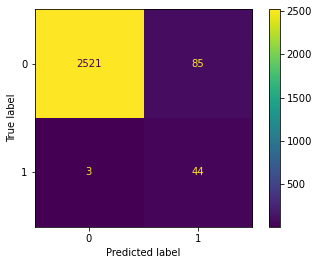

<IPython.core.display.Javascript object>

In [22]:
# define class weights
w = {
    0: 100
    * np.sum(y == "Malicious")
    / (np.sum(y == "Benign") + np.sum(y == "Malicious")),
    1: 100 * np.sum(y == "Benign") / (np.sum(y == "Benign") + np.sum(y == "Malicious")),
}

# define model
lg2 = LogisticRegression(
    solver="liblinear",  # "lbfgs",
    penalty="l1",
    random_state=13,
    class_weight="balanced",
    max_iter=5,
)


# String to int for classes
y_train2 = np.copy(y_train)
y_train2[np.where(y_train == "Benign")[0]] = 0
y_train2[np.where(y_train == "Malicious")[0]] = 1


# fit it
lg2.fit(X_train_scale, y_train2.astype("int32"))

# test
y_pred_wt = lg2.predict(X_test_scale)


y_test2 = np.copy(y_test)
y_test2[np.where(y_test == "Benign")[0]] = 0
y_test2[np.where(y_test == "Malicious")[0]] = 1


# performance
conf_mat = confusion_matrix(y_test2.astype("int32"), y_pred_wt)

print(f"Accuracy Score: {accuracy_score(y_test2.astype('int32'),y_pred_wt)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test2.astype('int32'), y_pred_wt)}")
print(f"Area Under Curve: {roc_auc_score(y_test2.astype('int32'), y_pred_wt)}")
print(
    f"Recall score (Pct of true malicious detected): {100*recall_score(y_test2.astype('int32'), y_pred_wt)}"
)
print(
    f"Data reduction: { np.round( 100.0 * conf_mat.T[1].sum() / conf_mat.sum() , 2 )} percent"
)

print(
    f"Pct malicious in data sent to console: { np.round( 100.0 * conf_mat.T[1][1] / conf_mat.T[1].sum() , 2 )} percent"
)

print("F1 score: ", f1_score(y_test2.astype("int32"), y_pred_wt, average="weighted"))

plot_confusion_matrix(lg2, X_test_scale, y_test2.astype("int32"))

In [317]:
np.savetxt("mean.txt", scaler.mean_, delimiter=",")
np.savetxt("std.txt", scaler.scale_, delimiter=",")
np.savetxt("weights.txt", lg2.coef_[0], delimiter=",")
np.savetxt("intercepts.txt", lg2.intercept_, delimiter=",")

# np.savetxt(filename, finalArray, delimiter=",")

<IPython.core.display.Javascript object>

In [50]:
lg2.coef_[0], len(lg2.coef_[0]), len(scaler.scale_)

(array([ 0.09073179, -0.03229318,  0.22515854,  0.0085294 ,  0.17921507,
         0.17299761,  0.16280228, -0.42517976,  0.04956075,  0.52144084,
        -0.11770784, -0.17583878, -0.11079877, -0.13699668,  0.3283902 ,
         0.04354703,  0.1357298 , -0.22102191]),
 18,
 18)

<IPython.core.display.Javascript object>

In [52]:
np.sum(np.multiply(lg2.coef_[0], np.divide((X_test[1] - scaler.mean_), scaler.scale_)))

0.056124596534096585

<IPython.core.display.Javascript object>

### Test webgoat

In [32]:
pd_webgoat_v4_features_cp = pd_webgoat_v4_features.copy(deep=True)

X_webgoat, y_webgoat = clean_dataset(pd_webgoat_v4_features_cp)

X_webgoat_scale = scaler.transform(X_webgoat)

(860, 19) (860, 18) (860,)


<IPython.core.display.Javascript object>

In [36]:
# test
y_webgoat_pred_wt = lg2.predict(X_webgoat_scale)


y_webgoat2 = np.copy(y_webgoat)
y_webgoat2[np.where(y_webgoat == "Benign")[0]] = 0
y_webgoat2[np.where(y_webgoat == "Malicious")[0]] = 1


# performance
conf_mat = confusion_matrix(y_webgoat2.astype("int32"), y_webgoat_pred_wt)

print(f"Accuracy Score: {accuracy_score(y_webgoat2.astype('int32'),y_webgoat_pred_wt)}")
print(
    f"Confusion Matrix: \n{confusion_matrix(y_webgoat2.astype('int32'), y_webgoat_pred_wt)}"
)
# print(f"Area Under Curve: {roc_auc_score(y_webgoat2.astype('int32'), y_webgoat_pred_wt)}")
print(
    f"Recall score (Pct of true malicious detected): {100*recall_score(y_webgoat2.astype('int32'), y_webgoat_pred_wt)}"
)
print(
    f"Data reduction: { np.round( 100.0 * conf_mat.T[1].sum() / conf_mat.sum() , 2 )} percent"
)

print(
    f"Pct malicious in data sent to console: { np.round( 100.0 * conf_mat.T[1][1] / conf_mat.T[1].sum() , 2 )} percent"
)

print(
    "F1 score: ",
    f1_score(y_webgoat2.astype("int32"), y_webgoat_pred_wt, average="weighted"),
)

plot_confusion_matrix(lg2, X_webgoat_scale, y_webgoat2.astype("int32"))

Accuracy Score: 1.0
Confusion Matrix: 
[[860]]
Recall score (Pct of true malicious detected): 100.0


IndexError: index 1 is out of bounds for axis 0 with size 1

<IPython.core.display.Javascript object>

In [129]:
pd_check = pd_webgoat_v4_features[
    pd_webgoat_v4["fiveTuple"]
    == "138.68.177.159--198.199.96.210--TCP--8080(http-alt)--51238"
][feature_cols]

X_check, y_check = clean_dataset(pd_check)

X_check_scale = scaler.transform(X_check)

print(lg2.predict(X_check_scale))

indx1 = 0
indx2 = 0
# print(
#     sigmoid(np.sum(np.multiply(X_check_scale[indx1, :], lg2.coef_[0]))),
#     np.sum(np.multiply(X_check_scale[indx1, :], lg2.coef_[0])),
# )
print(
    sigmoid(np.sum(np.multiply(X_check_scale[indx2, :], lg2.coef_[0]))),
    np.multiply(X_check_scale[indx2, :], lg2.coef_[0]),
    np.sum(np.multiply(X_check_scale[indx1, :], lg2.coef_[0])),
)

(1, 19) (1, 18) (1,)
[1]
0.9986786702798967 [-1.43351564e-01  1.15278158e-01  1.41640879e+00 -4.30544668e-02
 -2.74538224e-03 -2.84483104e-01 -1.70224882e-01  1.55211381e+00
  4.88247468e-02  3.14490031e+00  1.37016072e-01  8.48847200e-01
  2.21953757e-02  7.66257023e-03 -9.04321633e-02 -1.25025301e-02
 -7.38845691e-03  8.87299970e-02] 6.627794482273534


<IPython.core.display.Javascript object>

In [122]:
X_check_scale[indx2, :] 0.9986786703321138 6.627794521844508

array([-1.57994855, -3.56973688,  6.29071774, -5.04777007, -0.01531892,
       -1.6444337 , -1.04559275, -3.65048844,  0.98514939,  6.03117377,
       -1.1640352 , -4.82741754, -0.2003215 , -0.05593252, -0.27538022,
       -0.2871041 , -0.05443504, -0.40145339])

<IPython.core.display.Javascript object>

In [128]:
pd_check

,packetSizeMean,packetSizeStd,packetSizeMin,packetSizeMax,fwdPacketSizeMean,bwdPacketSizeMean,fwdPacketSizeStd,bwdPacketSizeStd,fwdPacketSizeMin,bwdPacketSizeMin,fwdPacketSizeMax,bwdPacketSizeMax,flowLengthPerTime,fwdFlowLengthPerTime,bwdFlowLengthPerTime,packetSizeTotalPerTime,fwdPacketSizeTotalPerTime,bwdPacketSizeTotalPerTime,Type
9,253.072289,98.843893,66.0,371.0,169.878049,334.285714,22.635171,73.86032,66.0,66.0,175.0,371.0,1.630785e-08,8.055684e-09,8.252164e-09,0.000004,0.000001,0.000003,Malicious


<IPython.core.display.Javascript object>

In [ ]:
138.68.177.159--198.199.96.210--TCP--8080(http-alt)--37004
138.68.177.159--198.199.96.210--TCP--8080(http-alt)--37206
138.68.177.159--198.199.96.210--TCP--8080(http-alt)--35562
138.68.177.159--198.199.96.210--TCP--8080(http-alt)--50480

### Test Burp

In [131]:
pd_burp_features_cp = pd_burp_features.copy(deep=True)

X_burp, y_burp = clean_dataset(pd_burp_features_cp)

X_burp_scale = scaler.transform(X_burp)

(1950, 19) (1950, 18) (1950,)


<IPython.core.display.Javascript object>

In [227]:
# test
y_burp_pred_wt = lg2.predict(X_burp_scale)

y_burp_pred_wt_probs = lg2.predict_proba(X_burp_scale)


y_burp2 = np.copy(y_burp)
y_burp2[np.where(y_burp == "Benign")[0]] = 0
y_burp2[np.where(y_burp == "Malicious")[0]] = 1


# performance
# conf_mat = confusion_matrix(y_burp2, y_burp_pred_wt)

conf_mat = confusion_matrix(y_burp2.astype("int32"), y_burp_pred_wt)

# print(f"Accuracy Score: {accuracy_score(y_burp2.astype('int32'),y_burp_pred_wt)}")
# print(
#     f"Confusion Matrix: \n{confusion_matrix(y_burp2.astype('int32'), y_burp_pred_wt)}"
# )
# # print(f"Area Under Curve: {roc_auc_score(y_burp2.astype('int32'), y_burp_pred_wt)}")
# print(
#     f"Recall score (Pct of true malicious detected): {100*recall_score(y_burp2.astype('int32'), y_burp_pred_wt)}"
# )
# print(
#     f"Data reduction: { np.round( 100.0 * conf_mat.T[1].sum() / conf_mat.sum() , 2 )} percent"
# )

# print(
#     f"Pct malicious in data sent to console: { np.round( 100.0 * conf_mat.T[1][1] / conf_mat.T[1].sum() , 2 )} percent"
# )

# print(
#     "F1 score: ", f1_score(y_burp2.astype("int32"), y_burp_pred_wt, average="weighted")
# )

# plot_confusion_matrix(lg2, X_burp_scale, y_burp2.astype("int32"))

<IPython.core.display.Javascript object>

In [270]:
y_burp_pred0 = y_burp_pred_wt_probs.T[0]
y_burp_pred1 = y_burp_pred_wt_probs.T[1]

y_burp_pred0, y_burp_pred1

(array([0.17512084, 0.1717296 , 0.17350986, ..., 0.1717296 , 0.17350987,
        0.17512078]),
 array([0.82487916, 0.8282704 , 0.82649014, ..., 0.8282704 , 0.82649013,
        0.82487922]))

<IPython.core.display.Javascript object>

In [268]:
y_burp_pred0 = y_burp_pred_wt_probs.T[0]
y_burp_pred1 = y_burp_pred_wt_probs.T[1]

y

(array([[0.17512084, 0.82487916],
        [0.1717296 , 0.8282704 ],
        [0.17350986, 0.82649014],
        ...,
        [0.1717296 , 0.8282704 ],
        [0.17350987, 0.82649013],
        [0.17512078, 0.82487922]]),
 array([[0.17512084, 0.1717296 , 0.17350986, ..., 0.1717296 , 0.17350987,
         0.17512078],
        [0.82487916, 0.8282704 , 0.82649014, ..., 0.8282704 , 0.82649013,
         0.82487922]]))

<IPython.core.display.Javascript object>

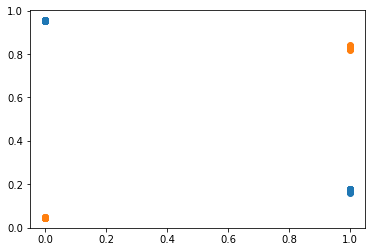

<IPython.core.display.Javascript object>

In [272]:
plt.scatter(y_burp_pred_wt, y_burp_pred_wt_probs.T[0])
plt.scatter(y_burp_pred_wt, y_burp_pred_wt_probs.T[1])
plt.show()

In [249]:
np.arange(len(y_burp_pred_wt_probs)).shape, y_burp_pred_wt_probs.shape

((1950,), (1950, 2))

<IPython.core.display.Javascript object>

In [231]:
np.unique(y_burp_pred_wt_probs)

array([0.0442198 , 0.04460107, 0.04460107, ..., 0.95539893, 0.95539893,
       0.9557802 ])

<IPython.core.display.Javascript object>

In [278]:
print(np.where(y_burp_pred_wt == 0)[0])

y_burp_pred_wt_probs.T[0][np.where(y_burp_pred_wt == 0)[0]]

[  95  122  142  314  318  417  437  473  499  504  532  537  549  602
  692  704  815  847  861  905  908  969 1010 1084 1149 1196 1332 1430
 1436 1452 1483 1757 1786 1787 1793 1911 1944]


array([0.95497551, 0.95497552, 0.95497551, 0.95497552, 0.95497551,
       0.95539892, 0.95385806, 0.95428789, 0.95497552, 0.95497551,
       0.95539893, 0.95385806, 0.95539892, 0.95497551, 0.95428789,
       0.95539893, 0.95385806, 0.95497552, 0.95539893, 0.95428789,
       0.95539892, 0.95497552, 0.95428789, 0.95539892, 0.95497552,
       0.95497551, 0.95497552, 0.95497551, 0.95497552, 0.95428789,
       0.95497552, 0.9557802 , 0.95539892, 0.95385806, 0.95497552,
       0.95497551, 0.95539893])

<IPython.core.display.Javascript object>

In [266]:
np.unique(y_burp_pred_wt)

array([0, 1], dtype=int32)

<IPython.core.display.Javascript object>

In [149]:
kk = pd_burp["fiveTuple"].unique()

kk[kk == "164.90.157.161--73.223.128.244--TCP--8080(http-alt)--53780"]

array(['164.90.157.161--73.223.128.244--TCP--8080(http-alt)--53780'],
      dtype=object)

<IPython.core.display.Javascript object>

In [329]:
pd_check = pd_burp_features[
    pd_burp["fiveTuple"] == "164.90.157.161--73.223.128.244--TCP--8080(http-alt)--53624"
][feature_cols]

X_check, y_check = clean_dataset(pd_check)

X_check_scale = scaler.transform(X_check)

print(lg2.predict_proba(X_check_scale), lg2.predict(X_check_scale))


(1, 19) (1, 18) (1,)
[[0.95385806 0.04614194]] [0]


<IPython.core.display.Javascript object>

In [311]:
arr = np.array(
    [
        [
            -1.81781296,
            -2.42164074,
            -0.13729295,
            -2.35991612,
            -0.01380899,
            -2.02682269,
            -0.03268177,
            -1.75908296,
            0.98514939,
            -0.12688304,
            -0.23441688,
            -2.13248545,
            -0.38805309,
            -0.25804838,
            -0.42524115,
            -0.33660912,
            -0.07533416,
            -15.275686137,
        ]
    ]
)

print(
    "A1",
    sigmoid( np.dot(arr, lg2.coef_[0])[0] + lg2.intercept_[0]  ),
    np.dot(arr, lg2.coef_[0])[0],
    np.sum(np.multiply(arr, lg2.coef_[0])),
)

print("A2", lg2.predict_proba(arr), lg2.predict(arr), lg1.predict(arr))


# print(
#     sigmoid(np.sum(np.multiply(arr, lg1.coef_[0]))),
#     np.multiply(arr, lg1.coef_[0]),
#     np.sum(np.multiply(arr, lg1.coef_[0])),
# )




A1 0.555032847058471 3.9270328576507403 3.92703285765074
A2 [[0.44496715 0.55503285]] [1] ['Benign']


<IPython.core.display.Javascript object>

In [ ]:
sigmoid( np.sum( np.multiply(arr, lg2.coef_[0]) + lg2.intercept_[0] ) )

In [300]:
lg2.intercept_[0]

-3.706006027593806

<IPython.core.display.Javascript object>

In [222]:
sigmoid(7.19)

0.9992464791014181

<IPython.core.display.Javascript object>

In [256]:
w

{0: 1.6287750254496098, 1: 98.37122497455039}

<IPython.core.display.Javascript object>

In [133]:
np.where(y_burp_pred_wt == 0), len(y_burp_pred_wt), X_burp_scale.shape

((array([  95,  122,  142,  314,  318,  417,  437,  473,  499,  504,  532,
          537,  549,  602,  692,  704,  815,  847,  861,  905,  908,  969,
         1010, 1084, 1149, 1196, 1332, 1430, 1436, 1452, 1483, 1757, 1786,
         1787, 1793, 1911, 1944]),),
 1950,
 (1950, 18))

<IPython.core.display.Javascript object>

In [135]:
indx1 = 95
indx2 = 94


print(sigmoid(np.sum(np.multiply(X_burp_scale[indx1, :], lg2.coef_[0]))))
print(sigmoid(np.sum(np.multiply(X_burp_scale[indx2, :], lg2.coef_[0]))))

0.6573544537256099
0.9949304686303589


<IPython.core.display.Javascript object>

In [75]:
164.90.157.161--73.223.128.244--TCP--8080(http-alt)--55761

array([-1.81781296, -2.42164074, -0.13729295, -2.35991612, -0.01380899,
       -2.02682269, -0.03268177, -1.75908296,  0.98514939, -0.12688304,
       -0.23441688, -2.13248545, -0.38805392, -0.25804936, -0.42524175,
       -0.33660929, -0.07533426, -0.45586151])

<IPython.core.display.Javascript object>

### ReadyAPI Vulnerability original

In [68]:
X_dum.shape, np.where(y_test == "Malicious")[0].shape

((52, 18), (52,))

<IPython.core.display.Javascript object>

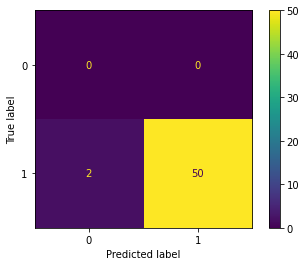

<IPython.core.display.Javascript object>

In [70]:
# String to int for classes
y_mal2 = np.copy(y_dum)
y_mal2[np.where(y_dum == "Benign")[0]] = 0
y_mal2[np.where(y_dum == "Malicious")[0]] = 1

plot_confusion_matrix(lg2, X_dum, y_mal2.astype("int32"))

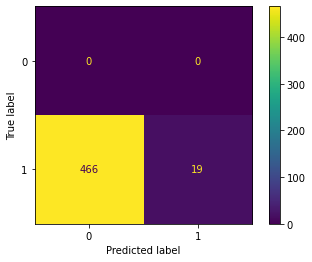

<IPython.core.display.Javascript object>

In [107]:
# String to int for classes
y_mal2 = np.copy(y_mal)
y_mal2[np.where(y_mal == "Benign")[0]] = 0
y_mal2[np.where(y_mal == "Malicious")[0]] = 1

plot_confusion_matrix(lg2, X_mal_scale, y_mal2.astype("int32"))

### Train

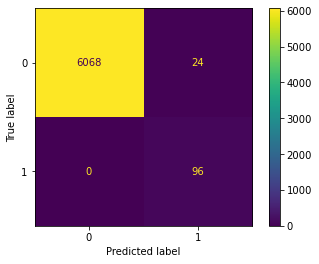

<IPython.core.display.Javascript object>

In [152]:
plot_confusion_matrix(lg2, X_train_scale, y_train2.astype("int32"))

In [30]:
# test
y_pred_mal_wt = lg2.predict(X_mal_scale)


y_mal2 = np.copy(y_mal)
y_mal2[np.where(y_mal == "Benign")[0]] = 0
y_mal2[np.where(y_mal == "Malicious")[0]] = 1

# performance
print(f"Accuracy Score: {accuracy_score(y_mal2.astype('int32'),y_pred_mal_wt)}")
# print(f"Confusion Matrix: \n{confusion_matrix(y_mal.astype('int32'), y_pred_mal_wt)}")
# print(f"Area Under Curve: {roc_auc_score(y_mal2.astype('int32'), y_pred_mal_wt)}")
print(f"Recall score: {recall_score(y_mal2.astype('int32'), y_pred_mal_wt)}")
print("F1 score: ", f1_score(y_mal2.astype("int32"), y_pred_mal_wt, average="weighted"))

plot_confusion_matrix(lg2, X_mal_scale, y_mal2.astype("int32"))

NameError: name 'X_mal_scale' is not defined

<IPython.core.display.Javascript object>

Accuracy Score: 0.9960272417707151
Confusion Matrix: 
[[1730    7]
 [   0   25]]
Area Under Curve: 0.9979850316637882
Recall score: 1.0


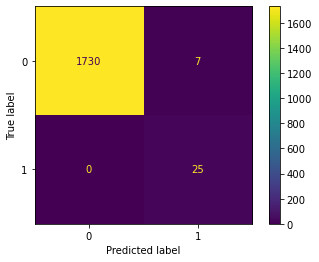

<IPython.core.display.Javascript object>

In [118]:
# define class weights
w = {
    0: 0.5,
    1: 99.5,
}

# define model
lg2 = LogisticRegression(
    solver="lbfgs", penalty="l2", random_state=13, class_weight=w, max_iter=1000,
)


# String to int for classes
y_train2 = np.copy(y_train)
y_train2[np.where(y_train == "Benign")[0]] = 0
y_train2[np.where(y_train == "Malicious")[0]] = 1


# fit it
lg2.fit(X_train_scale, y_train2.astype("int32"))

# test
y_pred_wt = lg2.predict(X_test_scale)


y_test2 = np.copy(y_test)
y_test2[np.where(y_test == "Benign")[0]] = 0
y_test2[np.where(y_test == "Malicious")[0]] = 1


# performance
print(f"Accuracy Score: {accuracy_score(y_test2.astype('int32'),y_pred_wt)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test2.astype('int32'), y_pred_wt)}")
print(f"Area Under Curve: {roc_auc_score(y_test2.astype('int32'), y_pred_wt)}")
print(f"Recall score: {recall_score(y_test2.astype('int32'), y_pred_wt)}")

plot_confusion_matrix(lg2, X_test_scale, y_test2.astype("int32"))

Accuracy Score: 0.9971703452178834
Confusion Matrix: 
[[1738    0]
 [   5   24]]
Area Under Curve: 0.9137931034482758
Recall score: 0.8275862068965517


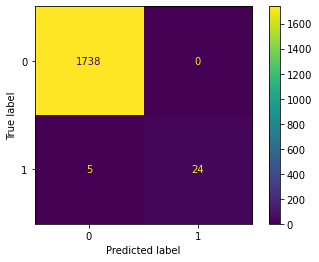

<IPython.core.display.Javascript object>

In [32]:
# define class weights
w = {
    0: 99,
    1: 1,
}

# define model
lg2 = LogisticRegression(
    solver="lbfgs", penalty="l2", random_state=13, class_weight=w, max_iter=1000,
)


# String to int for classes
y_train2 = np.copy(y_train)
y_train2[np.where(y_train == "Benign")[0]] = 0
y_train2[np.where(y_train == "Malicious")[0]] = 1


# fit it
lg2.fit(X_train_scale, y_train2.astype("int32"))

# test
y_pred_wt = lg2.predict(X_test_scale)


y_test2 = np.copy(y_test)
y_test2[np.where(y_test == "Benign")[0]] = 0
y_test2[np.where(y_test == "Malicious")[0]] = 1


# performance
print(f"Accuracy Score: {accuracy_score(y_test2.astype('int32'),y_pred_wt)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test2.astype('int32'), y_pred_wt)}")
print(f"Area Under Curve: {roc_auc_score(y_test2.astype('int32'), y_pred_wt)}")
print(f"Recall score: {recall_score(y_test2.astype('int32'), y_pred_wt)}")

plot_confusion_matrix(lg2, X_test_scale, y_test2.astype("int32"))

### Feature importance scores

In [67]:
importance = lg2.coef_[0]

<IPython.core.display.Javascript object>

In [68]:
importance

array([-0.44518773, -0.08533273, -1.06592098,  1.74855168, -0.91789374,
       -2.36642712,  0.        ,  0.        ,  1.45642695,  1.2574872 ,
       -2.26309654, -0.92220186,  0.        ,  0.        ,  1.61228028,
        0.        , -2.42815909,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

<IPython.core.display.Javascript object>

In [69]:
np.abs(importance)[np.argsort(-1 * np.abs(importance))]

array([2.42815909, 2.36642712, 2.26309654, 1.74855168, 1.61228028,
       1.45642695, 1.2574872 , 1.06592098, 0.92220186, 0.91789374,
       0.44518773, 0.08533273, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

<IPython.core.display.Javascript object>

In [70]:
pd_comb_features_cp.iloc[:, :-1].columns.values[np.argsort(-1 * np.abs(importance))]

array(['fwdIATMean', 'bwdPacketSizeMean', 'fwdPacketSizeMax',
       'packetSizeMax', 'IATMin', 'fwdPacketSizeMin', 'bwdPacketSizeMin',
       'packetSizeMin', 'bwdPacketSizeMax', 'fwdPacketSizeMean',
       'packetSizeMean', 'packetSizeStd', 'fwdPacketSizeStd',
       'packetSizeTotalPerTime', 'bwdFlowLengthPerTime',
       'fwdFlowLengthPerTime', 'flowLengthPerTime', 'bwdIATMax',
       'fwdIATMax', 'bwdIATMin', 'fwdIATMin', 'bwdIATStd', 'fwdIATStd',
       'bwdIATMean', 'IATMax', 'fwdPacketSizeTotalPerTime', 'IATStd',
       'IATMean', 'bwdPacketSizeStd', 'bwdPacketSizeTotalPerTime'],
      dtype=object)

<IPython.core.display.Javascript object>

In [111]:
pd_comb_features_cp.iloc[:, :-1].columns.values[np.argsort(-1 * np.abs(importance))]

array(['bwdPacketSizeMean', 'packetSizeMean', 'fwdFlowLengthPerTime',
       'fwdPacketSizeTotalPerTime', 'bwdPacketSizeTotalPerTime',
       'bwdPacketSizeMax', 'packetSizeMax', 'bwdIATMin',
       'fwdPacketSizeStd', 'fwdPacketSizeMax', 'bwdPacketSizeMin',
       'fwdPacketSizeMean', 'flowLengthPerTime', 'IATMean', 'bwdIATMean',
       'IATMin', 'fwdIATMin', 'fwdIATMean', 'IATStd', 'fwdIATMax',
       'IATMax', 'fwdIATStd', 'bwdFlowLengthPerTime', 'bwdPacketSizeStd',
       'bwdIATStd', 'bwdIATMax', 'fwdPacketSizeMin', 'packetSizeStd',
       'packetSizeMin'], dtype=object)

<IPython.core.display.Javascript object>